<a href="https://colab.research.google.com/github/bluebottle66/Practical-Machine-Learning-Northwestern-/blob/master/Predict422_Week5_Kun_Yang.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# seed value for random number generators to obtain reproducible results
RANDOM_SEED = 1
RANDOM_SEED_MODEL = 9999

In [0]:
import numpy as np
import pandas as pd

In [0]:
# visualization utilities
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages  # plot to pdf files

# user-defined function for displaying observations/handwritten digits
# adapted from Géron (2017) Python notebook code (default 10 images per row)
def plot_digits(instances, images_per_row = 10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = matplotlib.cm.binary, **options)
    plt.axis('off')

In [6]:
from sklearn.datasets.base import get_data_home 
print (get_data_home())

/root/scikit_learn_data


**Note:** running the original fetch_mldata code have connection reset error

I tried multiple time and it is not working. Try different approach to download mnist-original.mat to local location and run from there, seems not working well. 

End up using below approach where I found online, the .mat file is already in a shared github location, otherwise I tried to upload to my own github drive and the file is exceeding 25MB and I cannot upload there...




In [0]:
from six.moves import urllib
from sklearn.datasets import fetch_mldata

from scipy.io import loadmat
mnist_alternative_url = "https://github.com/amplab/datascience-sp14/raw/master/lab7/mldata/mnist-original.mat"
mnist_path = "./mnist-original.mat"
response = urllib.request.urlopen(mnist_alternative_url)
with open(mnist_path, "wb") as f:
  content = response.read()
  f.write(content)
  mnist_raw = loadmat(mnist_path)
  mnist = {
  "data": mnist_raw["data"].T,
  "target": mnist_raw["label"][0],
  "COL_NAMES": ["label", "data"],
  "DESCR": "mldata.org dataset: mnist-original",
  }

In [8]:
mnist

{'COL_NAMES': ['label', 'data'],
 'DESCR': 'mldata.org dataset: mnist-original',
 'data': array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8),
 'target': array([0., 0., 0., ..., 9., 9., 9.])}

In [0]:
mnist_X, mnist_y = mnist['data'], mnist['target']

In [10]:
print('\n Structure of explanatory variable array:', mnist_X.shape)
print('\n Structure of response array:', mnist_y.shape)


 Structure of explanatory variable array: (70000, 784)

 Structure of response array: (70000,)


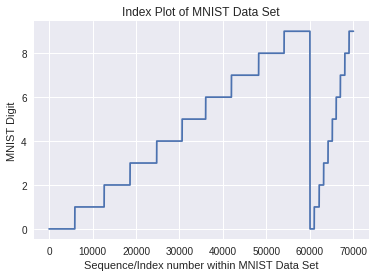

In [11]:
%matplotlib inline
with PdfPages('plot-mnist-index-plot.pdf') as pdf:
    fig, axis = plt.subplots()
    axis.set_xlabel('Sequence/Index number within MNIST Data Set')
    axis.set_ylabel('MNIST Digit')
    plt.title('Index Plot of MNIST Data Set')
    plt.plot(mnist_y[:,])
    #pdf.savefig()  # saves the current figure into a pdf page
    plt.show()
    #plt.close()

From above graph, we can see the raw data are order in sequence on index, so thats the reason I resample the data with randomness below before train the model

Below is to check the frenuency of how each digits appears in the training ans testing set. I want the 10 digits appeared at similar frequency so that we have enough and similar dataset to train our model to recognize each of the 10 digits


In [12]:
mnist_y_0_59999_df = pd.DataFrame({'label': mnist_y[0:59999,]}) 
print('\nFrequency distribution for 60,000 observations (for model building)')
print(mnist_y_0_59999_df['label'].value_counts(ascending = True))  


Frequency distribution for 60,000 observations (for model building)
5.0    5421
4.0    5842
8.0    5851
6.0    5918
0.0    5923
9.0    5948
2.0    5958
3.0    6131
7.0    6265
1.0    6742
Name: label, dtype: int64


In [13]:
mnist_y_60000_69999_df = pd.DataFrame({'label': mnist_y[60000:69999,]}) 
print('\nFrequency distribution for last 10,000 observations (holdout sample)')
print(mnist_y_60000_69999_df['label'].value_counts(ascending = True))  


Frequency distribution for last 10,000 observations (holdout sample)
5.0     892
6.0     958
8.0     974
0.0     980
4.0     982
9.0    1008
3.0    1010
7.0    1028
2.0    1032
1.0    1135
Name: label, dtype: int64


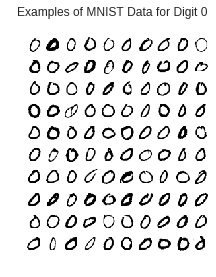

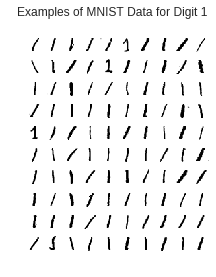

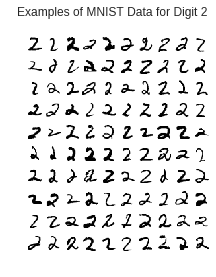

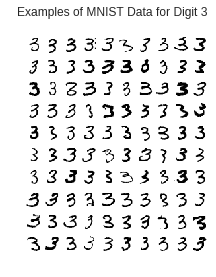

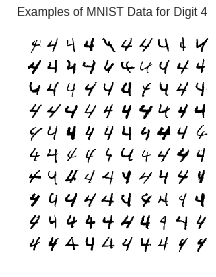

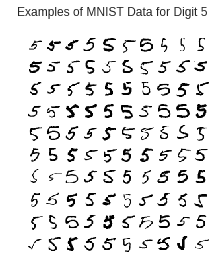

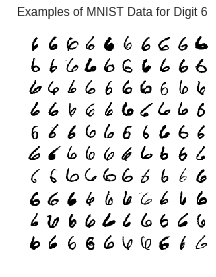

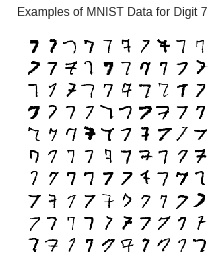

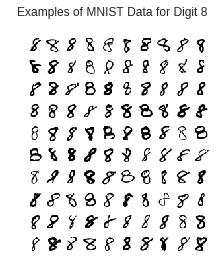

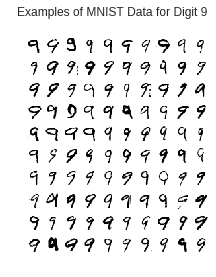

In [24]:
from sklearn.utils import resample

with PdfPages('plot-mnist-handwritten-digits-model-building-data.pdf') as pdf:
    for idigit in range(0,10):
        # print('\nworking on digit', idigit)
        
        # identify the index values from the first 60000 observations
        # that have the label equal to a specific digit (idigit)
        idigit_indices = \
            mnist_y_0_59999_df.index[mnist_y_0_59999_df.label == idigit]
        # obtain indices for 100 randomly sampled observations for this digit    
        show_indices = resample(idigit_indices, n_samples=100, 
                                replace = False, 
                                random_state = RANDOM_SEED).sort_values()       
        plt.figure(0)
        plt.suptitle('Examples of MNIST Data for Digit ' + str(idigit))
        # define beginning and ending row index for this digit
        # generate ten rows of ten digits each
        for j in range(0,10):
            row_begin_index = j * 10
            row_end_index = row_begin_index + 10
            # print('row begin',row_begin_index, 'row_end', row_end_index)
            this_row_indices = show_indices[row_begin_index:row_end_index]
            
            example_images = np.r_[mnist_X[this_row_indices]]
            # print(mnist_y[this_row_indices,])
            plt.subplot2grid((10,1), (j,0), colspan=1)
            # plot ten digits per row using user-defined function
            plot_digits(example_images, images_per_row=10)
            row_begin_index = row_end_index + 1
        #pdf.savefig()  
        #plt.close()
        plt.show()

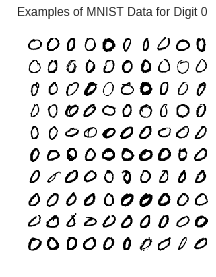

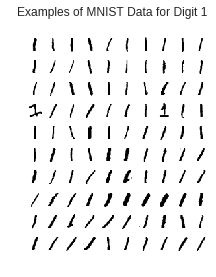

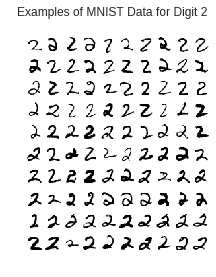

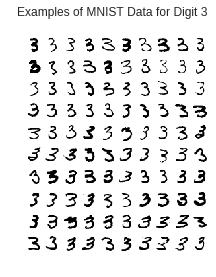

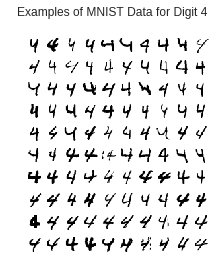

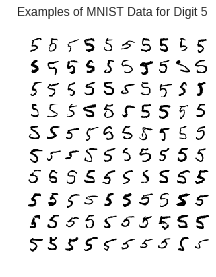

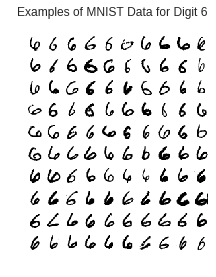

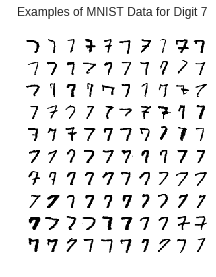

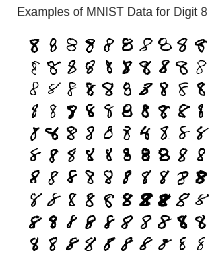

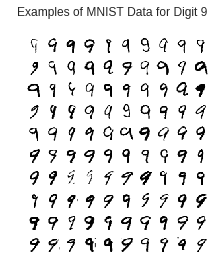

In [25]:
# also show samples from the holdout data (last 10000 observations)  
with PdfPages('plot-mnist-handwritten-digits-holdout-data.pdf') as pdf:
    for idigit in range(0,10):
        # print('\nworking on digit', idigit)
        
        # identify the index values from the first 60000 observations
        # that have the label equal to a specific digit (idigit)
        idigit_indices = 60000 + \
        mnist_y_60000_69999_df.index[mnist_y_60000_69999_df.label == idigit]
        # obtain indices for 100 randomly sampled observations for this digit    
        show_indices = resample(idigit_indices, n_samples=100, 
                                replace = False, 
                                random_state = RANDOM_SEED).sort_values()       
        plt.figure(0)
        plt.suptitle('Examples of MNIST Data for Digit ' + str(idigit))
        # define beginning and ending row index for this digit
        # generate ten rows of ten digits each
        for j in range(0,10):
            row_begin_index = j * 10
            row_end_index = row_begin_index + 10
            # print('row begin',row_begin_index, 'row_end', row_end_index)
            this_row_indices = show_indices[row_begin_index:row_end_index]
            
            example_images = np.r_[mnist_X[this_row_indices]]
            # print(mnist_y[this_row_indices,])
            plt.subplot2grid((10,1), (j,0), colspan=1)
            # plot ten digits per row using user-defined function
            plot_digits(example_images, images_per_row=10)
            row_begin_index = row_end_index + 1
        #pdf.savefig()  
        #plt.close()
        plt.show()

Create binary variables for all the 10 digits for model input usage:

> The sample code only create two binary variables for 0 & 1


>I am trying to create binary variables for all the remaining digits





In [14]:
model_indices_for_zeros = \
            mnist_y_0_59999_df.index[mnist_y_0_59999_df.label == 0]
model_indices_for_ones = \
            mnist_y_0_59999_df.index[mnist_y_0_59999_df.label == 1]
model_indices_for_twos = \
            mnist_y_0_59999_df.index[mnist_y_0_59999_df.label == 2]
model_indices_for_threes = \
            mnist_y_0_59999_df.index[mnist_y_0_59999_df.label == 3]
model_indices_for_fours = \
            mnist_y_0_59999_df.index[mnist_y_0_59999_df.label == 4]
model_indices_for_fives = \
            mnist_y_0_59999_df.index[mnist_y_0_59999_df.label == 5]
model_indices_for_sixs = \
            mnist_y_0_59999_df.index[mnist_y_0_59999_df.label == 6]
model_indices_for_sevens = \
            mnist_y_0_59999_df.index[mnist_y_0_59999_df.label == 7]
model_indices_for_eights = \
            mnist_y_0_59999_df.index[mnist_y_0_59999_df.label == 8]
model_indices_for_nines = \
            mnist_y_0_59999_df.index[mnist_y_0_59999_df.label == 9]

model_indices = np.append(model_indices_for_zeros, 
                          model_indices_for_ones
                          )
model_indices = np.append(model_indices,
                          model_indices_for_twos
                         )
model_indices = np.append(model_indices,
                          model_indices_for_threes
                         )
model_indices = np.append(model_indices,
                          model_indices_for_fours
                         )
model_indices = np.append(model_indices,
                          model_indices_for_fives
                         )
model_indices = np.append(model_indices,
                          model_indices_for_sixs
                         )
model_indices = np.append(model_indices,
                          model_indices_for_sevens
                         )
model_indices = np.append(model_indices,
                          model_indices_for_eights
                         )
model_indices = np.append(model_indices,
                          model_indices_for_nines
                         )

model_y = np.r_[mnist_y[model_indices]]
model_X = np.r_[mnist_X[model_indices]]
model_data = np.concatenate((model_y.reshape(-1, 1), model_X), axis = 1)

# check on shape of the model_data array
print('\nShape of model_data:', model_data.shape)


Shape of model_data: (59999, 785)


In [15]:
holdout_indices_for_zeros = 60000 + \
            mnist_y_60000_69999_df.index[mnist_y_60000_69999_df.label == 0]
holdout_indices_for_ones = 60000 + \
            mnist_y_60000_69999_df.index[mnist_y_60000_69999_df.label == 1]
holdout_indices_for_twos = 60000 + \
            mnist_y_60000_69999_df.index[mnist_y_60000_69999_df.label == 2]
holdout_indices_for_threes = 60000 + \
            mnist_y_60000_69999_df.index[mnist_y_60000_69999_df.label == 3]
holdout_indices_for_fours = 60000 + \
            mnist_y_60000_69999_df.index[mnist_y_60000_69999_df.label == 4]
holdout_indices_for_fives = 60000 + \
            mnist_y_60000_69999_df.index[mnist_y_60000_69999_df.label == 5]
holdout_indices_for_sixs = 60000 + \
            mnist_y_60000_69999_df.index[mnist_y_60000_69999_df.label == 6]
holdout_indices_for_sevens = 60000 + \
            mnist_y_60000_69999_df.index[mnist_y_60000_69999_df.label == 7]
holdout_indices_for_eights = 60000 + \
            mnist_y_60000_69999_df.index[mnist_y_60000_69999_df.label == 8]
holdout_indices_for_nines = 60000 + \
            mnist_y_60000_69999_df.index[mnist_y_60000_69999_df.label == 9]

holdout_indices = np.append(holdout_indices_for_zeros, 
                            holdout_indices_for_ones)
holdout_indices = np.append(holdout_indices, 
                            holdout_indices_for_twos)
holdout_indices = np.append(holdout_indices, 
                            holdout_indices_for_threes)
holdout_indices = np.append(holdout_indices, 
                            holdout_indices_for_fours)
holdout_indices = np.append(holdout_indices, 
                            holdout_indices_for_fives)
holdout_indices = np.append(holdout_indices, 
                            holdout_indices_for_sixs)
holdout_indices = np.append(holdout_indices, 
                            holdout_indices_for_sevens)
holdout_indices = np.append(holdout_indices, 
                            holdout_indices_for_eights)
holdout_indices = np.append(holdout_indices, 
                            holdout_indices_for_nines)

holdout_y = np.r_[mnist_y[holdout_indices]]
holdout_X = np.r_[mnist_X[holdout_indices]]
holdout_data = np.concatenate((holdout_y.reshape(-1, 1), 
                               holdout_X), axis = 1)

# check on shape of the holdout_data array
print('\nShape of holdout_data:', holdout_data.shape)


Shape of holdout_data: (9999, 785)


In [0]:
np.random.seed(RANDOM_SEED)
np.random.shuffle(model_data)

np.random.seed(RANDOM_SEED)
np.random.shuffle(holdout_data)

In [18]:
#conducting PCA analysis on trainning set to reduce dimension
from sklearn.decomposition import PCA
import time
t0=time.time()
pca = PCA(n_components=0.95)
X_reduced = pca.fit_transform(model_data)
t1=time.time()
print("PCA on full 70000 dataset took {:.2f}s".format(t1 - t0))
print(pca.n_components_)
np.sum(pca.explained_variance_ratio_)

PCA on full 70000 dataset took 15.53s
154


0.9501955166316727

In [0]:
# --------------------------------------------------------
# cross-validation scoring code adapted from Scikit Learn documentation


# specify the set of classifiers being evaluated
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix


names = ["Random_Forest","SoftMax_Regression"]
classifiers = [RandomForestClassifier(n_estimators=100, max_features='sqrt',bootstrap=True,
                        random_state=0),
              LogisticRegression(multi_class="multinomial", solver="lbfgs", random_state=42)]

In [25]:
from sklearn.model_selection import KFold
from sklearn.metrics import f1_score


N_FOLDS = 10

print('\nProgress with' + str(N_FOLDS) + '-fold cross-validation')

# set up numpy array for storing results
cv_results = np.zeros((N_FOLDS, len(names)))
RF_results = np.zeros((N_FOLDS, len(names)))

kf = KFold(n_splits = N_FOLDS, shuffle=False, random_state = RANDOM_SEED)
# check the splitting process by looking at fold observation counts
index_for_fold = 0  # fold count initialized 


for train_index, test_index in kf.split(model_data):
    print('\nFold index:', index_for_fold,
          '------------------------------------------')
#   the structure of modeling data for this study has the
#   response variable coming first and explanatory variables later          
#   so 1:model_data.shape[1] slices for explanatory variables
#   and 0 is the index for the response variable    
    X_train = model_data[train_index, 1:model_data.shape[1]]
    X_test = model_data[test_index, 1:model_data.shape[1]]
    y_train = model_data[train_index, 0]
    y_test = model_data[test_index, 0]   
    print('\nShape of input data for this fold:',
          '\nData Set: (Observations, Variables)')
    print('X_train:', X_train.shape)
    print('X_test:',X_test.shape)
    print('y_train:', y_train.shape)
    print('y_test:',y_test.shape)

    index_for_method = 0  # initialize
    for name, clf in zip(names, classifiers):
        print('\nClassifier evaluation for:', name)
        print('  Scikit Learn method:', clf)
        
        t0=time.time()
        clf.fit(X_train, y_train)  # fit on the train set for this fold
        t1=time.time()
        RF_time=t1-t0
        print("Training took {:.2f}s".format(t1 - t0))
        RF_results[index_for_fold, index_for_method]=RF_time
        
        # evaluate on the test set for this fold
        y_test_predict=clf.predict(X_test)
        y_test_predict_proba = clf.predict_proba(X_test)
                
        print("Validation Accuracy: " + str(accuracy_score(y_test,y_test_predict)))
        print("Validation Confusion Matrix: \n" + str(confusion_matrix(y_test,y_test_predict)))
        fscore=f1_score(y_test,y_test_predict, average='micro')
        print("Validation f1 score: " + str(fscore))

        cv_results[index_for_fold, index_for_method] = fscore
        
        index_for_method += 1
  
    index_for_fold += 1

cv_results_df = pd.DataFrame(cv_results)
rf_results_df = pd.DataFrame(RF_results)

print('\n----------------------------------------------')
print('Average f1 score results from ', N_FOLDS, '-fold cross-validation\n')     
print(cv_results_df.mean()) 
print('\n----------------------------------------------')
print('Average random forest time from ', N_FOLDS, '-fold cross-validation\n')     
print(rf_results_df.mean()) 


Progress with10-fold cross-validation

Fold index: 0 ------------------------------------------

Shape of input data for this fold: 
Data Set: (Observations, Variables)
X_train: (53999, 784)
X_test: (6000, 784)
y_train: (53999,)
y_test: (6000,)

Classifier evaluation for: Random_Forest
  Scikit Learn method: RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=0, verbose=0, warm_start=False)
Training took 60.29s
Validation Accuracy: 0.9696666666666667
Validation Confusion Matrix: 
[[604   0   0   0   0   1   2   0   1   0]
 [  0 709   3   1   1   0   0   2   1   0]
 [  1   1 568   3   3   0   3   2   2   0]
 [  2   1   5 594   0   6   3   7   5   2]
 [  0   0   3   0 5

In [39]:
np.random.seed(RANDOM_SEED)
np.random.shuffle(model_data)

np.random.seed(RANDOM_SEED)
np.random.shuffle(holdout_data)

N_FOLDS=10
print('\nProgress with' + str(N_FOLDS) + '-fold cross-validation')

# set up numpy array for storing results
cv2_results = np.zeros((N_FOLDS, len(names)))
PCA_results = np.zeros((N_FOLDS, len(names)))
RF_PCA_results = np.zeros((N_FOLDS, len(names)))
total_time_results = np.zeros((N_FOLDS, len(names)))


kf = KFold(n_splits = N_FOLDS, shuffle=False, random_state = RANDOM_SEED)
# check the splitting process by looking at fold observation counts
index_for_fold = 0  # fold count initialized 


for train_index, test_index in kf.split(model_data):
    print('\nFold index:', index_for_fold,
          '------------------------------------------')
#   the structure of modeling data for this study has the
#   response variable coming first and explanatory variables later          
#   so 1:model_data.shape[1] slices for explanatory variables
#   and 0 is the index for the response variable    
    X_train = model_data[train_index, 1:model_data.shape[1]]
    X_test = model_data[test_index, 1:model_data.shape[1]]
    y_train = model_data[train_index, 0]
    y_test = model_data[test_index, 0]   
    print('\nShape of input data for this fold:',
          '\nData Set: (Observations, Variables)')
    print('X_train:', X_train.shape)
    print('X_test:',X_test.shape)
    print('y_train:', y_train.shape)
    print('y_test:',y_test.shape)

    index_for_method = 0  # initialize
    for name, clf in zip(names, classifiers):
        print('\nClassifier evaluation for:', name)
        print('  Scikit Learn method:', clf)
        
        t0=time.time()
        pca = PCA(n_components = 154)
        X_train_reduced = pca.fit_transform(X_train)
        t1=time.time()
        PCA_time=t1-t0
        print("PCA took {:.2f}s".format(t1 - t0))
        PCA_results[index_for_fold, index_for_method]=PCA_time
        
        
        t0=time.time()
        clf.fit(X_train_reduced, y_train)  # fit on the train set for this fold
        t1=time.time()
        RF_PCA_time=t1-t0
        print("Training took {:.2f}s".format(t1 - t0))
        RF_PCA_results[index_for_fold, index_for_method]=RF_PCA_time
        
        # evaluate on the test set for this fold
        
        X_test_reduced = pca.fit_transform(X_test)
        y_test_predict=clf.predict(X_test_reduced)
        y_test_predict_proba = clf.predict_proba(X_test_reduced)
                
        print("Validation Accuracy: " + str(accuracy_score(y_test,y_test_predict)))
        print("Validation Confusion Matrix: \n" + str(confusion_matrix(y_test,y_test_predict)))
        fscore=f1_score(y_test,y_test_predict, average='micro')
        print("Validation f1 score: " + str(fscore))

        cv2_results[index_for_fold, index_for_method] = fscore
        total_time_results[index_for_fold, index_for_method] = RF_PCA_time+PCA_time
        
        
        index_for_method += 1
  
    index_for_fold += 1

cv2_results_df = pd.DataFrame(cv2_results)
PCA_results_df = pd.DataFrame(PCA_results)
RF_PCA_results_df = pd.DataFrame(RF_PCA_results)
total_time_results_df = pd.DataFrame(total_time_results)

print('\n----------------------------------------------')
print('Average f1 score results from ', N_FOLDS, '-fold cross-validation\n')     
print(cv2_results_df.mean()) 
print('\n----------------------------------------------')
print('Average PCA time from ', N_FOLDS, '-fold cross-validation\n')     
print(PCA_results_df.mean()) 
print('\n----------------------------------------------')
print('Average Random Forest with PCA time from ', N_FOLDS, '-fold cross-validation\n')     
print(RF_PCA_results_df.mean()) 
print('\n----------------------------------------------')
print('Average total time from ', N_FOLDS, '-fold cross-validation\n')     
print(total_time_results_df.mean()) 


Progress with10-fold cross-validation

Fold index: 0 ------------------------------------------

Shape of input data for this fold: 
Data Set: (Observations, Variables)
X_train: (53999, 784)
X_test: (6000, 784)
y_train: (53999,)
y_test: (6000,)

Classifier evaluation for: Random_Forest
  Scikit Learn method: RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=0, verbose=0, warm_start=False)
PCA took 10.68s
Training took 110.89s
Validation Accuracy: 0.33716666666666667
Validation Confusion Matrix: 
[[528   0  14   7  16  10   9   8  16   4]
 [  0 106   5  17 195   1   3 305   1  62]
 [  4   0 307   9  94   5  42  47  26  45]
 [  3   0  12  97 115  29   5 174  40 123]
 

Above PCA results looks rather bad....I would like to try a different way for a quick test below without doing the cross-validation. 

Instead of creating those binary variables,  use raw data directly to built the model for a test.

In [30]:
X_train = mnist['data'][:60000]
y_train = mnist['target'][:60000]

X_test = mnist['data'][60000:]
y_test = mnist['target'][60000:]

clf = RandomForestClassifier(random_state=0)

t0 = time.time()
clf.fit(X_train, y_train)
t1 = time.time()
print("Training took {:.2f}s".format(t1 - t0))

y_pred = clf.predict(X_test)
accuracy_score(y_test, y_pred)

Training took 6.82s


0.9484

In [34]:
#now do a PCA:
t0=time.time()
pca = PCA(n_components=154)
X_train_reduced = pca.fit_transform(X_train)
X_test_reduced = pca.fit_transform(X_test)
t1=time.time()
print("PCA took {:.2f}s".format(t1 - t0))


PCA took 12.99s


In [38]:
clf2 = RandomForestClassifier(random_state=0)
t0 = time.time()
clf2.fit(X_train_reduced, y_train)
t1 = time.time()
print("New Training took {:.2f}s".format(t1 - t0))

pca = PCA(n_components=154)


y_pred = clf2.predict(X_test_reduced)
accuracy_score(y_test, y_pred)

New Training took 11.95s


0.1204

Looks like the result is similar, also very bad... we can see after PCA, the accuracy is down to 0,12 only. PCA took 12.99s, and new training took 11.95s. so in total close to 25s.

before doing PCA, the training only take 6.82s to achieve 0.94 accuracy

So based on above results, we should not use PCA + Random Forest for this question, instead we should use the original data directly